# 🧠 Real-time Entity Classifier - CNN Architecture

This notebook defines the convolutional neural network (CNN) architecture that will classify webcam frames into one of the following categories:

- 🐱 **Pet** (my girlfriend's sphynx cat, Lucy)
- 👤 **Pet Owner** (me, Sebastian)
- 🧍 **Another Person**  
- 🚫 **Nobody Present**

The CNN architecture is designed to extract meaningful features from real-time video input and make an accurate classification based on the detected subject.  
It is lightweight and suitable for live webcam processing while respecting user privacy. 🔒

<hr>

## 📦 PyTorch Imports Overview

To build and train our convolutional neural network (CNN), we import key components from the **PyTorch** framework:

- **`torch`**: The main PyTorch library, which provides core functionalities such as tensor operations, model creation, and automatic differentiation. It is the backbone of PyTorch.

- **`torch.nn`**: This module offers essential tools for building neural networks, such as `Conv2d` for convolutional layers, `Linear` for fully connected layers, and many other layers and utilities that help define and train models.

- **`torch.nn.functional`**: A functional interface to neural network operations. It includes commonly used functions like `ReLU`, `Sigmoid`, and others, providing flexibility and stateless operations. These functions are typically used directly in the `forward()` method of a model.

- **`torch.optim`**: Contains optimization algorithms like Adam, SGD, and more. These are used to update the model’s weights during training, minimizing the loss function.

- **`torchvision.transforms`**: A collection of image transformation utilities that allow us to preprocess and augment image data, like resizing, normalization, and random flips. This is essential when working with image datasets.

- **`torchvision.datasets`**: Provides easy access to popular datasets. In this project, we use **`datasets.ImageFolder`**, which is designed to load images organized into class-specific folders. It helps us load and manage custom datasets where images are stored in a directory structure.

- **`DataLoader`**: A utility that simplifies data loading, batching, and shuffling, ensuring that our data is efficiently processed during training and evaluation.

- **`tqdm`**: A Python library that adds a progress bar to loops, making it easy to monitor the progress of long-running operations, such as training over multiple epochs.

- **`matplotlib.pyplot`**: A plotting library used to visualize key metrics like training loss and accuracy over time, helping us understand the model’s performance during training.

These imports form the foundation for constructing, training, and evaluating our deep learning model. 🧠

In [121]:
# Importing the necessary libraries for deep learning with PyTorch

# Importing torch for tensor operations and model creation
import torch

# Importing neural network modules to build and train neural networks
import torch.nn as nn

# Importing functional APIs from PyTorch for operations like activation functions
import torch.nn.functional as F

# Importing torch.optim for various optimization algorithms (like Adam, SGD)
import torch.optim as optim

# Importing transforms and datasets for image processing and loading standard datasets
from torchvision import transforms
from torchvision import datasets

# Importing DataLoader to handle batching and shuffling of data
from torch.utils.data import DataLoader

# Importing tqdm to visualize progress in loops (like during training)
from tqdm import tqdm

# Importing matplotlib for plotting graphs and visualizing metrics
import matplotlib.pyplot as plt


from torchvision import models

import cv2
from PIL import Image
from torch.utils.data import Dataset

<hr>

## 🧠 CNN Model Definition & Architecture Explanation

We define a Convolutional Neural Network (CNN) model called `EntityClassifierCNN`, designed to classify webcam frames into one of four categories:

### 🎯 Classification Targets:
1. **Pet** – my girlfriend’s Sphynx cat, Lucy 🐱  
2. **Owner** – me, Sebastian 👨  
3. **Other Person** – anyone who is not the owner 🧍  
4. **None** – when no person or pet is present 🚫

### 🧱 Model Architecture Overview:

The model follows a standard convolutional architecture:

- **Three Convolutional Layers**:
  - Each convolution uses a **3×3 kernel** with **padding of 1** to preserve spatial dimensions, and **stride being 1** by default.
  - The number of output feature maps increases across layers: **32 → 64 → 128**.
  - After each convolution, a **ReLU activation** is applied, followed by **2×2 MaxPooling**, which halves the spatial resolution.

- **Fully Connected Layers**:
  - The output of the final convolutional layer is **flattened** and passed to a fully connected layer with **512 neurons**.
  - A **Dropout layer** with a probability of **0.3** is applied to reduce overfitting.
  - The final fully connected layer outputs **logits for 4 classes**, one for each possible classification.

### 🔁 Forward Pass Flow:

1. Input image (assumed to be RGB, 3 channels)  
2. Conv → ReLU → MaxPool  
3. Conv → ReLU → MaxPool  
4. Conv → ReLU → MaxPool  
5. Flatten  
6. Fully connected → ReLU → Dropout  
7. Final fully connected layer → Output scores for each class

In [51]:
class EntityClassifierCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(EntityClassifierCNN, self).__init__()  # Call the constructor of nn.Module
        
        # MaxPooling layer with kernel_size=2 and stride=2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Convolutional Layer 1: 
        # in_channels=3 (RGB), out_channels=32, kernel_size=3x3, padding=1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        
        # Convolutional Layer 2: 
        # in_channels=32 (from previous layer), out_channels=64, kernel_size=3x3, padding=1
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # Convolutional Layer 3:
        # in_channels=64, out_channels=128, kernel_size=3x3, padding=1
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Fully Connected Layer 1:
        # input features = 128 channels * 28 * 28 (flattened), output features = 512
        self.fc1 = nn.Linear(in_features=128 * 28 * 28, out_features=512)
        
        # Fully Connected Layer 2 (Output Layer):
        # input features = 512, output features = num_classes (default 4)
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)
        
        # Dropout with probability = 0.3
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Output: 112x112
        x = self.pool(F.relu(self.conv2(x)))  # Output: 56x56
        x = self.pool(F.relu(self.conv3(x)))  # Output: 28x28
        x = x.view(-1, 128 * 28 * 28)         # Flatten
        x = self.dropout(F.relu(self.fc1(x))) # Apply dropout after activation
        return self.fc2(x)                    # Output logits

<hr>

## Model, Optimizer, and Loss Function Setup

### 1. **Model Instantiation** 🧑‍💻
We instantiate the `EntityClassifierCNN` model

### 2. **Optimizer Setup** ⚙️
We set up our optimizer for this task as **Adam** 🚀, a popular and highly efficient choice for training deep learning models. The Adam optimizer adapts the learning rate for each parameter during training, making it more efficient and faster in practice compared to other optimizers like **SGD** (Stochastic Gradient Descent). Unlike SGD, which uses a fixed learning rate for all parameters, Adam dynamically adjusts the learning rate based on individual parameter updates, which helps achieve faster convergence and better performance on complex tasks. We specify a learning rate of **0.001** as a starting point, but this can be fine-tuned based on experimentation.

### 3. **Loss Function Setup** ⚖️
For our multi-class classification task, we use **CrossEntropyLoss** as our loss function. Cross-entropy loss combines `log_softmax` and `NLLLoss` to efficiently calculate the difference between the predicted class probabilities and the true labels. It is well-suited for multi-class classification problems because it directly optimizes the model to correctly classify each class.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
import matplotlib.pyplot as plt

# --- Improved Model Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True).to(device)

# 2. Freeze all layers except classifier (saves computation)
for param in model.parameters():
    param.requires_grad = False

# 3. Modify classifier for 4 classes
model.classifier[1] = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.2),  # Helps prevent overfitting
    nn.Linear(256, 4)  # 4 output classes
).to(device)

# Initialize weights properly (critical for training)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)
model.classifier[1].apply(init_weights)

# 4. Optimizer (only train classifier parameters)
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=0.001, weight_decay=1e-5)  # Added L2 regularization

# 5. Loss function
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Helps with class imbalance

# --- Quick Verification ---
print(f"Model loaded on {device}")
print("Classifier structure:")
print(model.classifier)

Model loaded on cpu
Classifier structure:
Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Sequential(
    (0): Linear(in_features=1280, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=4, bias=True)
  )
)


C:\Users\dosqas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dosqas\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<hr>

## 📦 DataLoader and Dataset Setup

Before training our model, we need to properly load and preprocess the image data. This is handled using PyTorch’s `ImageFolder` and `DataLoader` utilities.

### 🖼️ Image Preprocessing
We define a series of transformations to ensure consistency and improve model performance:
- **Resize**: All images are resized to a fixed dimension of **224x224** pixels. This is a common size for CNNs and ensures a uniform input shape.
- **ToTensor**: Images are converted into PyTorch tensors, enabling them to be processed by the model.
- **Normalize**: Pixel values are normalized using the mean and standard deviation from the ImageNet dataset:
  - Mean: `[0.485, 0.456, 0.406]`
  - Standard Deviation: `[0.229, 0.224, 0.225]`
  This helps with model convergence and consistency.

### 🗂️ Dataset Structure
The dataset is organized using folders representing each class. Each subdirectory (e.g., `nobody`, `pet`, `owner`, `other_person`) contains images specific to that class. PyTorch’s `ImageFolder` automatically maps these folders to class labels.

### 🛠️ DataLoader Creation
We create two `DataLoader` objects:
- **Training Loader**: Loads the dataset in shuffled batches of 32 images to ensure randomness and improve generalization.
- **Validation Loader**: Loads the validation data without shuffling, maintaining the order for consistent evaluation.

The `num_workers=4` setting allows data loading to happen in parallel for better performance.


In [1]:
import torch
import cv2
import numpy as np
import random
import os
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

class VideoFrameDataset(Dataset):
    def __init__(self, video_paths, label_mapping, transform=None, 
                 augment=False, num_augments=3, bg_paths=None, 
                 face_image_dir=None, max_frames_per_video=300):
        """
        Args:
            video_paths: Dictionary of video paths for each class
            label_mapping: Dictionary mapping class names to labels
            transform: Torchvision transforms
            augment: Whether to apply augmentations
            num_augments: Number of augmented versions per frame
            bg_paths: List of background videos/image directories
            face_image_dir: Path to directory containing face images
            max_frames_per_video: Maximum frames to sample from each video
        """
        self.video_paths = video_paths
        self.label_mapping = label_mapping
        self.transform = transform
        self.augment = augment
        self.num_augments = num_augments
        self.bg_paths = bg_paths or []
        self.face_image_dir = face_image_dir
        self.max_frames_per_video = max_frames_per_video
        
        # Instead of storing frames, store frame references
        self.frame_sources = []  # Will contain (source_type, path, frame_idx, label)
        self.class_counts = {name: 0 for name in label_mapping}
        
        self._index_all_data()
        
        if len(self.frame_sources) == 0:
            raise ValueError("No valid frames were indexed. Please check your input paths.")
        
        total_samples = len(self.frame_sources)
        if self.augment:
            total_samples *= (1 + self.num_augments)
            
        print(f"\nDataset created with {total_samples} samples")
        print("Class distribution:")
        for name, idx in label_mapping.items():
            count = self.class_counts[name] * (1 + self.num_augments if self.augment else 1)
            print(f"- {name}: {count} samples ({count/total_samples:.1%})")

    def _index_all_data(self):
        """Index data sources without loading frames into memory"""
        print("\n" + "="*50)
        print("STARTING DATA INDEXING")
        print("="*50)
        
        # Index owner video
        if "owner" in self.video_paths:
            print("\n" + "-"*20)
            print("INDEXING OWNER VIDEOS")
            print("-"*20)
            for path in self.video_paths["owner"]:
                print(f"\nIndexing: {path}")
                self._index_video(path, self.label_mapping["owner"], "owner")

        # Index pet video
        if "pet" in self.video_paths:
            print("\n" + "-"*20)
            print("INDEXING PET VIDEOS")
            print("-"*20)
            for path in self.video_paths["pet"]:
                print(f"\nIndexing: {path}")
                self._index_video(path, self.label_mapping["pet"], "pet")

        # Index face images if directory provided
        if self.face_image_dir:
            print("\n" + "-"*20)
            print("INDEXING FACE IMAGES FROM DIRECTORY")
            print("-"*20)
            print(f"Directory: {self.face_image_dir}")
            
            face_paths = glob(os.path.join(self.face_image_dir, "*.jpg")) + \
                        glob(os.path.join(self.face_image_dir, "*.jpeg")) + \
                        glob(os.path.join(self.face_image_dir, "*.png"))
            
            if face_paths:
                print(f"Found {len(face_paths)} face images")
                # Sample exactly 350 faces (or all if less available)
                sample_size = min(350, len(face_paths))
                print(f"Randomly sampling {sample_size} faces...")
                sampled_paths = random.sample(face_paths, sample_size)
                
                for i, img_path in enumerate(sampled_paths, 1):
                    if i % 100 == 0:  # Print progress every 100 images
                        print(f"Indexed {i}/{len(sampled_paths)} face images")
                    self._index_image(img_path, self.label_mapping["other"], "other")
                print(f"Finished indexing {len(sampled_paths)} face images")
            else:
                print(f"No face images found in {self.face_image_dir}")

        # Index background data
        if self.bg_paths:
            print("\n" + "-"*20)
            print("INDEXING BACKGROUND DATA")
            print("-"*20)
            for path in self.bg_paths:
                if os.path.isdir(path):
                    print(f"\nIndexing background images from: {path}")
                    img_paths = [
                        f for f in glob(os.path.join(path, "*")) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                    ]
                    if img_paths:
                        sample_size = min(400, len(img_paths))
                        print(f"Found {len(img_paths)} images, sampling {sample_size}...")
                        sampled_paths = random.sample(img_paths, sample_size)
                        for i, img_path in enumerate(sampled_paths, 1):
                            if i % 100 == 0:
                                print(f"Indexed {i}/{len(sampled_paths)} background images")
                            self._index_image(img_path, self.label_mapping["background"], "background")
                    else:
                        print(f"No valid images found in {path}")
                else:
                    print(f"\nIndexing background video: {path}")
                    self._index_video(path, self.label_mapping["background"], "background")

        print("\n" + "="*50)
        print("DATA INDEXING COMPLETE")
        print("="*50)

    def _index_video(self, path, label, class_name):
        """Index frames from a video without loading them"""
        try:
            if not os.path.exists(path):
                print(f"Error: File not found - {path}")
                return
    
            cap = cv2.VideoCapture(path)
            if not cap.isOpened():
                print(f"Error: Could not open video - {path}")
                return
    
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if total_frames == 0:
                print(f"Warning: Video has 0 frames - {path}")
                cap.release()
                return
    
            # Calculate exact number of frames to sample
            target_frames = min(self.max_frames_per_video, total_frames)
            step = max(1, total_frames // target_frames)
            
            print(f"Indexing {target_frames} frames from {total_frames} total frames")
            
            frames_indexed = 0
            frame_indices = list(range(0, total_frames, step))[:target_frames]
            
            # Just store references to the frames
            for frame_idx in frame_indices:
                self.frame_sources.append(("video", path, frame_idx, label))
                frames_indexed += 1
                self.class_counts[class_name] += 1
    
            cap.release()
            print(f"Indexed {frames_indexed} frames from {path}")
    
        except Exception as e:
            print(f"Error indexing video {path}: {str(e)}")

    def _index_image(self, img_path, label, class_name):
        """Index an image file without loading it"""
        try:
            if not os.path.exists(img_path):
                print(f"Error: File not found - {img_path}")
                return

            # Just store reference to the image
            self.frame_sources.append(("image", img_path, 0, label))
            self.class_counts[class_name] += 1
            
        except Exception as e:
            print(f"Error indexing image {img_path}: {str(e)}")

    def __len__(self):
        base_len = len(self.frame_sources)
        if self.augment:
            return base_len * (1 + self.num_augments)
        return base_len

    def __getitem__(self, idx):
        try:
            # Calculate which frame and whether this is an augmented version
            if self.augment:
                base_idx = idx // (1 + self.num_augments)
                aug_version = idx % (1 + self.num_augments)
            else:
                base_idx = idx
                aug_version = 0
                
            # Get the frame source info
            source_type, path, frame_idx, label = self.frame_sources[base_idx]
            
            # Load the frame on demand
            if source_type == "video":
                frame = self._load_video_frame(path, frame_idx)
            else:  # image
                frame = self._load_image(path)
                
            # Apply augmentation if needed
            if aug_version > 0:
                frame = self._augment_frame(frame)
            
            # Apply standard transformation
            if self.transform:
                if not isinstance(frame, Image.Image):
                    frame = Image.fromarray(frame)
                frame = self.transform(frame)
            
            return frame, torch.tensor(label, dtype=torch.long)
            
        except Exception as e:
            print(f"Error getting item {idx}: {str(e)}")
            # Return a simple default item instead of recursion
            dummy_data = torch.zeros((3, 224, 224))
            return dummy_data, torch.tensor(0, dtype=torch.long)

    def _load_video_frame(self, video_path, frame_idx):
        """Load a specific frame from a video"""
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        cap.release()
        
        if not ret or frame is None:
            raise ValueError(f"Failed to load frame {frame_idx} from {video_path}")
            
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    def _load_image(self, img_path):
        """Load an image from path"""
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Failed to load image {img_path}")
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def _augment_frame(self, frame):
        """Apply random augmentations"""
        augmenter = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomApply([
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
            ], p=0.8),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        ])
        return augmenter(frame)


# --- Example usage ---
if __name__ == "__main__":
    # Paths config
    label_mapping = {
        "owner": 0,    # You
        "pet": 1,      # Your cat
        "other": 2,    # Other people
        "background": 3  # Empty background
    }

    video_paths = {
        "owner": ["../data/owner/owner.mp4"],
        "pet": ["../data/pet/pet.mp4"],
    }

    bg_paths = [
        "../data/background/background.mp4"
    ]

    face_image_dir = "../data/other_people/other_people"

    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        print("Creating dataset...")
        dataset = VideoFrameDataset(
            video_paths=video_paths,
            label_mapping=label_mapping,
            transform=transform,
            augment=True,
            num_augments=2,
            bg_paths=bg_paths,
            face_image_dir=face_image_dir,
            max_frames_per_video=150
        )
        
        # Start with fewer workers for testing
        dataloader = DataLoader(
            dataset,
            batch_size=16,  # Increased batch size
            shuffle=True,
            num_workers=0,  # Start with 0 workers for testing
            pin_memory=torch.cuda.is_available()
        )
        
        print("Testing dataloader...")
        for i, (x, y) in enumerate(dataloader):
            print(f"Batch {i}: x shape = {x.shape}, y shape = {y.shape}")
            if i == 2:  # Limit output
                break
        print("Dataloader test successful!")
        
    except Exception as e:
        print(f"Error: {str(e)}")

Creating dataset...

STARTING DATA INDEXING

--------------------
INDEXING OWNER VIDEOS
--------------------

Indexing: ../data/owner/owner.mp4
Indexing 150 frames from 12212 total frames
Indexed 150 frames from ../data/owner/owner.mp4

--------------------
INDEXING PET VIDEOS
--------------------

Indexing: ../data/pet/pet.mp4
Indexing 150 frames from 915 total frames
Indexed 150 frames from ../data/pet/pet.mp4

--------------------
INDEXING FACE IMAGES FROM DIRECTORY
--------------------
Directory: ../data/other_people/other_people
Found 500 face images
Randomly sampling 350 faces...
Indexed 100/350 face images
Indexed 200/350 face images
Indexed 300/350 face images
Finished indexing 350 face images

--------------------
INDEXING BACKGROUND DATA
--------------------

Indexing background video: ../data/background/background.mp4
Indexing 150 frames from 1765 total frames
Indexed 150 frames from ../data/background/background.mp4

DATA INDEXING COMPLETE

Dataset created with 2400 samples

<hr>

## 🧠 Model Training Loop Explained

This section explains the logic behind training our deep learning model using PyTorch.

### 🔁 Epochs

We train the model over **100 epochs** — one epoch is a complete pass over the entire training dataset. Repeating this allows the model to learn gradually and improve its performance over time.

### 📊 Metrics Tracked

During training, we monitor two key metrics every epoch:
- **Loss** (📉): Measures how far off the model’s predictions are from the actual labels.
- **Accuracy** (✅): Tells us how many predictions were correct out of the total.

These are stored in `train_losses` and `train_accuracies` lists to help us visualize progress later.

### 🔄 Training Steps Per Epoch

Each epoch consists of several steps that happen for every batch of images:

1. **Set model to training mode** 🏋️  
   Enables dropout and batch normalization, which behave differently during training.

2. **Loop through batches of data** 📦  
   We use `tqdm` to wrap our DataLoader, which gives us a nice real-time progress bar.

3. **Zero out gradients** 🧽  
   We reset gradients using `optimizer.zero_grad()` so that past gradient values don’t accumulate.

4. **Forward pass** 📤  
   The input images are passed through the model to generate predictions.

5. **Calculate loss** 📏  
   We use a loss function (CrossEntropyLoss) to compute how wrong the model was.

6. **Backward pass** 🧮  
   We call `.backward()` on the loss to compute gradients of the model parameters.

7. **Update weights** 🔧  
   The optimizer (Adam) updates the model parameters based on the gradients with `optimizer.step()`.

8. **Track loss and accuracy** 🧾  
   We add the loss to a running total and count how many predictions were correct.

### 🧮 After Each Epoch

Once all batches are processed in an epoch:
- We calculate the **average loss** and **accuracy** for that epoch.
- We print this info to the console.
- We append the values to our tracking lists for later use.

### 💾 Saving the Model

At the end of training, we save the learned weights of our model to a file `entity_classifier.pth`. This allows us to reuse the model later without retraining it from scratch! 💡

### 📈 Plotting Metrics

We use `matplotlib` to generate two side-by-side plots:
- **Training Loss per Epoch** (in red)
- **Training Accuracy per Epoch** (in green)

These plots visually show how well the model learned over time — ideally, loss should decrease while accuracy increases! 📉📈

Starting model training...
🔥 Starting training process...
Using device: cpu
Dataset contains 2400 samples
Batch size: 16
Number of batches: 150
Model architecture:
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (co

Epoch 1/10: 100%|██████████████████████████████████████████████| 150/150 [05:10<00:00,  2.07s/it, acc=93.9, loss=0.177]


Epoch 1 | Loss: 0.1773 | Acc: 93.88%


Epoch 2/10: 100%|████████████████████████████████████████████████| 150/150 [05:12<00:00,  2.09s/it, acc=96, loss=0.115]


Epoch 2 | Loss: 0.1146 | Acc: 96.04%


Epoch 3/10: 100%|█████████████████████████████████████████████| 150/150 [04:06<00:00,  1.64s/it, acc=97.9, loss=0.0634]


Epoch 3 | Loss: 0.0634 | Acc: 97.88%


Epoch 4/10: 100%|█████████████████████████████████████████████| 150/150 [04:07<00:00,  1.65s/it, acc=98.8, loss=0.0433]


Epoch 4 | Loss: 0.0433 | Acc: 98.75%


Epoch 5/10: 100%|██████████████████████████████████████████████| 150/150 [04:04<00:00,  1.63s/it, acc=98.9, loss=0.037]


Epoch 5 | Loss: 0.0370 | Acc: 98.88%


Epoch 6/10: 100%|█████████████████████████████████████████████| 150/150 [04:04<00:00,  1.63s/it, acc=98.7, loss=0.0465]


Epoch 6 | Loss: 0.0465 | Acc: 98.67%


Epoch 7/10: 100%|█████████████████████████████████████████████| 150/150 [04:02<00:00,  1.62s/it, acc=98.7, loss=0.0428]


Epoch 7 | Loss: 0.0428 | Acc: 98.67%


Epoch 8/10: 100%|█████████████████████████████████████████████| 150/150 [04:06<00:00,  1.64s/it, acc=97.4, loss=0.0807]


Epoch 8 | Loss: 0.0807 | Acc: 97.38%


Epoch 9/10: 100%|█████████████████████████████████████████████| 150/150 [04:01<00:00,  1.61s/it, acc=98.9, loss=0.0302]


Epoch 9 | Loss: 0.0302 | Acc: 98.92%


Epoch 10/10: 100%|████████████████████████████████████████████| 150/150 [04:08<00:00,  1.66s/it, acc=98.2, loss=0.0591]


Epoch 10 | Loss: 0.0591 | Acc: 98.21%
Model saved to entity_classifier.pth


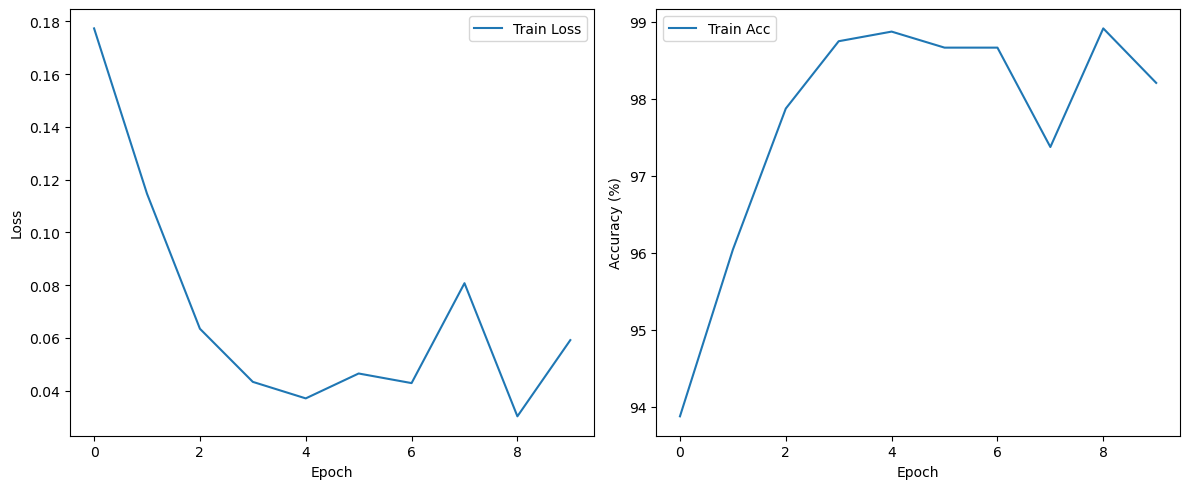

In [9]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    print("🔥 Starting training process...")
    # Move model to the specified device
    model.to(device)
    
    # Lists to store metrics for plotting
    train_losses = []
    train_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Initialize progress bar
        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
        
        for batch_idx, (images, labels) in enumerate(loop):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass - simplified since we're no longer dealing with lists of frames
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Update statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            loop.set_postfix(
                loss=running_loss/(batch_idx+1),
                acc=100.*correct/total
            )
        
        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%')
    
    # Save model
    torch.save(model.state_dict(), 'entity_classifier.pth')
    print('Model saved to entity_classifier.pth')
    
    # Plot results
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_results.png')  # Save the plot before showing it
    plt.show()
    
    return model

# Complete setup and training code
def setup_and_train(pretrained_model, dataloader, learning_rate=0.001, num_epochs=10):
    # Define loss function and optimizer
    criterion = torch.nn.CrossEntropyLoss()
    
    # Configure optimizer
    optimizer = torch.optim.Adam(pretrained_model.parameters(), lr=learning_rate)
    
    # Set device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Train the model
    print("Starting model training...")
    trained_model = train_model(
        model=pretrained_model,
        train_loader=dataloader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device
    )
    
    return trained_model

trained_model = setup_and_train(
    pretrained_model=model,  # Your model instance (e.g., models.resnet18())
    dataloader=dataloader,   # Your DataLoader from VideoFrameDataset
    learning_rate=0.001,          # Optional (default is 0.001)
    num_epochs=10                 # Optional (default is 10)
)

🎉 **Success!** Our model is now fully trained and we have the metrics to prove it! 🎉

We've completed the training process, and our model is ready for action. By evaluating the **training loss** and **accuracy** over the epochs, we can confirm the model’s progress and how well it has learned from the data.

Now that we've achieved solid performance on the training set, it's time to move on to **real-time inference**! 🚀

<hr>

### What’s next? 👀
Instead of continuing in a notebook, the next step is to integrate the trained model into a **PyCharm application** for real-time usage. We'll use the model to make predictions on live data, such as from a **webcam feed**. This allows us to test the model’s performance in real-world scenarios and see how it handles new, unseen data in an interactive application.

Let’s take the model for a spin and see how it performs when it’s really put to work in a **PyCharm app**. 💻✨